# Проект: вариант 1

# Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from scipy.stats import norm

import requests 
from urllib.parse import urlencode

In [2]:
# Загрузим наши данные с Яндекс-диска:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 

public_key = 'https://disk.yandex.ru/d/4lq_u9NdA2ZKtg'
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href']

In [3]:
df2 = pd.read_csv(download_url, sep=';')
df2.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


a - контрольная группа.  
b - тестовая группа. 

In [4]:
# Для удобства последующих рассчетов заведем несколько переменных
a_with0 = "testgroup=='a'"
a_without0 = "testgroup=='a' and revenue>0"

b_with0 = "testgroup=='b'"
b_without0 = "testgroup=='b' and revenue>0"

**Посчитаем основные показатели**

In [5]:
# Посмотрим на выручку по группам
revenue_a = df2.query(a_with0).revenue.sum()
revenue_b = df2.query(b_with0).revenue.sum()
print('Revenue контрольной группы:', round(revenue_a, 2))
print('Revenue тестовой группы   :', round(revenue_b, 2))
print('Revenue тестовой группы больше на ', revenue_b - revenue_a)


# Количество пользователей
users_a = df2.query(a_with0).user_id.count()
users_b = df2.query(b_with0).user_id.count()
print('Количество пользователей контрольной группы:', round(users_a, 2))
print('Количество пользователей тестовой группы   :', round(users_b, 2))

# Количество платящих пользователей
paying_users_a = df2.query(a_without0).user_id.count()
paying_users_b = df2.query(b_without0).user_id.count()
print('Количество платящих пользователей контрольной группы:', round(paying_users_a, 2))
print('Количество платящих пользователей тестовой группы   :', round(paying_users_b, 2))

# Конверсия пользователей в платящих
conv_topay_a = paying_users_a / users_a * 100
conv_topay_b = paying_users_b / users_b * 100
print('Конверсия в платящих пользователей контрольной группы:', round(conv_topay_a, 2), '%')
print('Конверсия в платящих пользователей тестовой группы   :', round(conv_topay_b, 2), '%')
 
# Получим показатели ARPU
arpu_a = revenue_a / users_a
arpu_b = revenue_b / users_b
print('ARPU контрольной группы:', round(arpu_a, 2))
print('ARPU тестовой группы   :', round(arpu_b, 2))

# Теперь ARPPU
arppu_a = revenue_a / paying_users_a
arppu_b = revenue_b / paying_users_b
print('ARPPU контрольной группы:', round(arppu_a, 2))
print('ARPPU тестовой группы   :', round(arppu_b, 2))

Revenue контрольной группы: 5136189
Revenue тестовой группы   : 5421603
Revenue тестовой группы больше на  285414
Количество пользователей контрольной группы: 202103
Количество пользователей тестовой группы   : 202667
Количество платящих пользователей контрольной группы: 1928
Количество платящих пользователей тестовой группы   : 1805
Конверсия в платящих пользователей контрольной группы: 0.95 %
Конверсия в платящих пользователей тестовой группы   : 0.89 %
ARPU контрольной группы: 25.41
ARPU тестовой группы   : 26.75
ARPPU контрольной группы: 2664.0
ARPPU тестовой группы   : 3003.66


In [6]:
print('ARPU тестовой группы на', round((arpu_b - arpu_a) / arpu_a * 100, 2), '% больше контрольной')

ARPU тестовой группы на 5.26 % больше контрольной


Итак, что мы видим:
* Revenue и ARPPU выше в тестовой группе
* При этом конверсия выше в контрольной группе

<AxesSubplot:xlabel='revenue', ylabel='testgroup'>

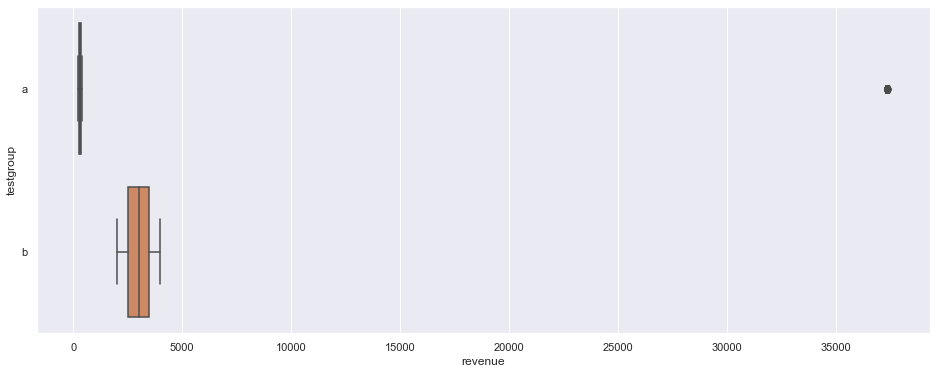

In [7]:
# Оценим визуально разброс ненулевой выручки:
sns.set(rc={'figure.figsize': (16, 6)})
sns.boxplot(data=df2.query('revenue !=0'), y='testgroup', x='revenue')

В контрольной группе виден явный **выброс** в виде продаж с высоким чеком.

Сравним данные при помощи bootstrap. Для этого будем использовать функцию из наших лекций

In [8]:
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2))  # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

**Сравниваем контрольную и тестовую группы без дополнительной обработки**

  0%|          | 0/1000 [00:00<?, ?it/s]

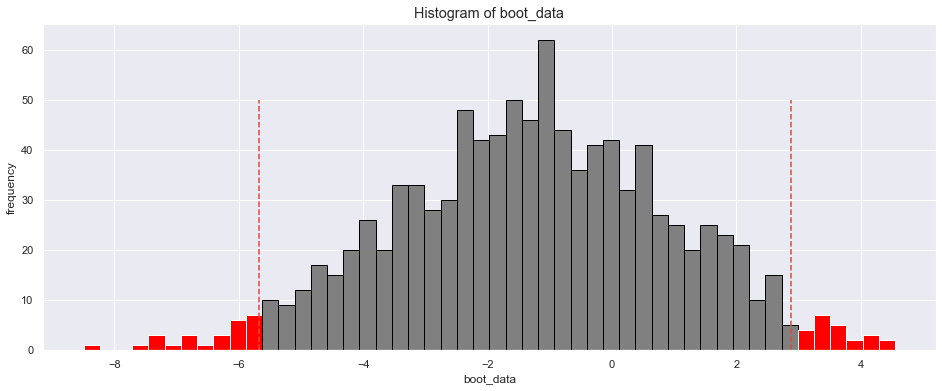

In [9]:
booted_data = get_bootstrap(
    df2.query(a_with0).revenue,
    df2.query(b_with0).revenue)

Результаты теста говорят об отсутствии статистической значимости между выборками (Ноль на графике попадает в доверительный интевал).

In [10]:
print('P-value:')
booted_data["p_value"]

P-value:


0.5611577635783951

P-value больше 0.05, что не позволяет нам отклонить гипотезу об отсутствии разницы между контрольной и тестовой группами

**Теперь сделаем тоже самое для платящих пользователей**

  0%|          | 0/1000 [00:00<?, ?it/s]

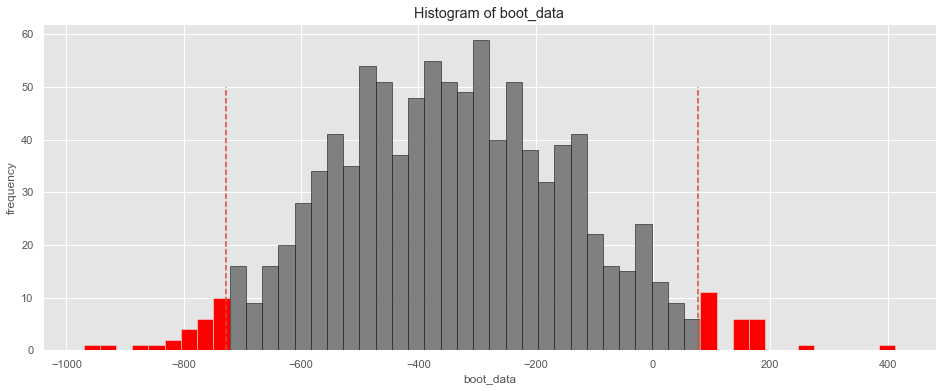

In [11]:
booted_data2 = get_bootstrap(
    df2.query(a_without0).revenue,
    df2.query(b_without0).revenue)

In [12]:
print('P-value:')
booted_data2["p_value"]

P-value:


0.09673787753378896

P-value всё еще больше 0.05 и мы не можем отклонить гипотезу об отсутствии разницы **ARPPU** в контрольной и тестовой группах

**Анализ выброса**   
Теперь проанализируем выброс покупок с высоким чеком. У нас к сожалению нет данных по датам покупок, но можно выдвинуть предположение, что это была оплата годовой подписки или другая акция, приуроченная к конкретной дате. Поскольку в тестовую выборку такие покупки не попали, то в таком случае сравнивать их будет не корректно. Сравним наши выборки еще раз, но теперь без группы высоких чеков:

  0%|          | 0/1000 [00:00<?, ?it/s]

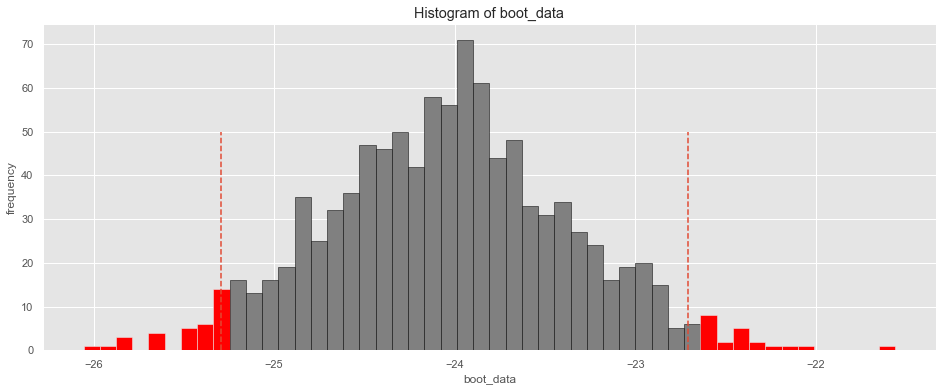

In [13]:
booted_data3 = get_bootstrap(
    df2.query("testgroup=='a' and revenue < 35000").revenue,
    df2.query(b_with0).revenue)

In [15]:
print('P-value:')
round(booted_data3["p_value"], 5)

P-value:


0.0

Даже с присуствием неплатящих пользователей мы видим значительную статистическую разницу между выборками.

**Выводы**

Мы сравнили метрики ARPU и ARPPU, для них статистически значимые различия не подтвердились.  
Но, если наше предположение о сезонности высоких чеков верно, то мы можем утверждать что **разница между выборками есть** и эксперимент прошел успешно, изменения можно раскатывать на всех пользователей.